In [3]:
import os
import dotenv
from langchain_community.embeddings import DashScopeEmbeddings
from openai import OpenAI
dotenv.load_dotenv()

# 初始化大语言模型
DASHSCOPE_API_KEY = os.getenv("DASHSCOPE_API_KEY")
llm =OpenAI(
    base_url=f"http://localhost:8000/v1/",
    api_key="EMPTY",
)

def get_completion(prompt, model="Qwen1.5-7B-Chat"):
    '''封装openai 接'''
    messages = [{"role": "user", "content": prompt}]
    response = llm.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0, #模型输出的随机性，0表示随机性最小
        max_tokens=256
    )
    return response.choices[0].message.content

# 创建嵌入模型
embeddings = DashScopeEmbeddings(
    model="text-embedding-v1",
    dashscope_api_key=DASHSCOPE_API_KEY
)

In [4]:
from langchain.prompts.loading import load_prompt
prompt_generate = load_prompt(path="prompts_template_generate.json", encoding='utf-8')
prompt_agent = load_prompt(path="prompts_template_agent.json", encoding='utf-8')
prompt_grade = load_prompt(path="prompts_template_grade.json", encoding='utf-8')
prompt_rewrite = load_prompt(path="prompts_template_rewrite.json", encoding='utf-8')

In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.tools import tool
from langchain_chroma import Chroma

# 定义 State
class State(TypedDict):
    # 状态变量 messages 类型是 list，更新方式是 add_messages
    # add_messages 是内置的一个方法，将新的消息列表追加在原列表后面
    messages: Annotated[list, add_messages]
    contexts: list
    messages_update: bool
    router_after_superagent: str
    router_after_grade:str
    times_rewrite: int
    router_after_rewrite: str

In [ ]:
vector_store = Chroma(
    collection_name="health_docs",
    embedding_function=embeddings,
    persist_directory="./chroma_db",  # Where to save data locally, remove if not necessary
)
vector_retriever = vector_store.as_retriever(search_kwargs={"k": 6})

In [7]:
def super_agent(state: State):
    print(">>> Agent Super")
    user_input = state["messages"][-1]
    message_input = prompt_agent.invoke({"question": user_input}).text
    response = get_completion(message_input)
    types_res = response
    print(types_res)
    return {"router_after_superagent": types_res, "messages_update":False}

def retrieval(state: State):
    cur_message = state['messages'][-1]
    user_query = cur_message.content
    docs = vector_retriever.invoke(user_query)
    contexts = [doc.page_content for doc in docs]
    ragas_contexts.append(contexts)
    return {"contexts": contexts, "messages_update":False}

def grade_docs(state: State):
    print(">>> grade docments")
    user_query = state['messages'][-1]
    context = state["contexts"]
    message_input = prompt_grade.invoke({"question": user_query,"context": context}).text
    response = get_completion(message_input)
    print(response)
    return {"router_after_grade": response, "messages_update":False}

def rewrite(state: State):
    print(">>> rewrite question")
    tr = state['times_rewrite']
    if tr > 3:
        return {"router_after_rewrite": "done"}
    user_query = state['messages'][-1]
    history = state["messages"]
    print(f"*********&&&&&&history:\n{history}")
    message_input = prompt_rewrite.invoke({"question": user_query,"history": history}).text
    response = get_completion(message_input)
    return {"router_after_rewrite": "super_agent", 
            "messages":[HumanMessage(content=response)], 
            "times_rewrite": tr+1,
            "messages_update":True}

def generate(state: State):
    user_query = state['messages'][-1].content
    message_input = prompt_generate.invoke({"question": user_query,"context": state['contexts']}).text
    response = get_completion(message_input)
    ragas_answers.append(response)
    return {"messages": [AIMessage(content=response)], "messages_update":True}

In [8]:
# 条件路由
def router_after_superagent(state: State):
    if state["router_after_superagent"] == "retrieve":
        return "retrieval"
    elif state["router_after_superagent"] == "rewrite":
        return "rewrite"
    elif state["router_after_superagent"] == "done":
        return END

def router_after_grade(state: State):
    if state["router_after_grade"] == "yes":
        return "generate"
    elif state["router_after_grade"] == "no":
        return "rewrite"

graph_builder = StateGraph(State)
graph_builder.add_node("super_agent", super_agent)
graph_builder.add_node("retrieval", retrieval)
graph_builder.add_node("generate", generate)
graph_builder.add_node("rewrite", rewrite)
graph_builder.add_node("grade_docs", grade_docs)

graph_builder.add_edge(START, "super_agent")
graph_builder.add_conditional_edges("super_agent", router_after_superagent,
                                    ["retrieval", "rewrite", END])
graph_builder.add_edge("retrieval", "grade_docs")
graph_builder.add_conditional_edges("grade_docs", router_after_grade,
                                    ["generate", "rewrite"])
graph_builder.add_edge("rewrite", "super_agent")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

def stream_graph_updates(user_input: str):
    input_message = {"messages": [HumanMessage(content=user_input)], "messages_update":True, "times_rewrite":0}
    for event in graph.stream(input_message, stream_mode="values"):
        if event["messages_update"]:
            last_message = event["messages"][-1]
            last_message.pretty_print()

In [ ]:
# from IPython.display import Image, display
# from langchain_core.runnables.graph import MermaidDrawMethod
# # 可视化展示这个工作流
# try:
#     display(Image(data=graph.get_graph().draw_mermaid_png()))
# except Exception as e:
#     print(e)

In [ ]:
# query = ["什么是TSGR", "它有哪些模块"]
# for q in query:
#     stream_graph_updates(q)

# 质量评估

In [9]:
from datasets import Dataset
import json

questions, ground_truths = [], []
with open("QApairs.json", 'r', encoding='utf-8') as f:
    data = json.load(f)
for item in data['questions']:
    questions.append(item['question'])
    ground_truths.append(item['answer'])

# print(questions, ground_truths)

In [10]:
import time

start = time.time()
ragas_answers, ragas_contexts = [], []
len_ragas_answers, len_ragas_contexts = 0, 0
for q in questions:
    stream_graph_updates(q)
    if len(ragas_answers) == len_ragas_answers:
        ragas_answers.append('No answer')
    if len(ragas_contexts) == len_ragas_contexts:
        ragas_contexts.append(['No contexts'])
    len_ragas_answers += 1
    len_ragas_contexts += 1
end_time = time.time()

================================ Human Message =================================

fMRI的主要应用领域有哪些？
>>> Agent Super
retrieve
>>> grade docments
yes
================================== Ai Message ==================================

fMRI的主要应用领域包括但不限于以下几个方面：

1. 认知神经科学：它扩展了我们对认知功能的理解，如Cabeza (2001)、Raichle (2001)和Poldrack (2008, 2012)等人的研究。

2. 健康与疾病研究：由于其在无主动参与任务（rs-fMRI）中的应用，使得这项技术在临床和研究中非常有用。

3. 精神疾病：如Addiction behavior（Chase and Clark, 2010; Kober et al., 2016）、Neuromarketing（Ariely and Berns, 2010; Kuhn et al., 2016）和政治学（Knutson et al., 2006）等领域都有应用。

4. 小体积脑成像：高分辨率的fMRI使得研究小型哺乳动物如老鼠（Jonckers et al., 2011; Schlegel et al., 2015）和其他动物成为可能，如大鼠、非人类灵长类、狗和猫。

5.
================================ Human Message =================================

fMRI实验设计中常见的类型有哪些？
>>> Agent Super
retrieve
>>> grade docments
yes
================================== Ai Message ==================================

fMRI实验设计中常见的类型包括：

1. 休息状态（Resting State）：这是最直接的，用于研究大脑在静息时的活动模式。
2. 任务相关设计（Task-based）：通过结合刺激物在连续块或事件相

In [11]:
print(end_time-start)
## 30个问题，329.6936116218567s
## vllm 188.37236857414246

# ragas_answers[28] = 'No answer'
# print(ragas_answers[28])

166.92019963264465


In [12]:
# To dict
data = {
    "user_input": questions,
    "response": ragas_answers,
    "retrieved_contexts": ragas_contexts,
    "reference": ground_truths
}
 
# Convert dict to dataset
dataset = Dataset.from_dict(data)
dataset

Dataset({
    features: ['user_input', 'response', 'retrieved_contexts', 'reference'],
    num_rows: 30
})

In [ ]:
# 评测结果
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

from langchain_community.llms import Tongyi
llm = Tongyi(
    model_name="qwen-max", 
    dashscope_api_key=DASHSCOPE_API_KEY
)

result = evaluate(
    dataset = dataset, 
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
    ],
    llm=llm,
    embeddings=embeddings
)
 
df = result.to_pandas()
df


Evaluating:  28%|██▊       | 33/120 [00:51<02:57,  2.04s/it]Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
Prompt statement_generator_prompt failed to parse output: The output parser failed to parse the output including retries.
Exception raised in Job[10]: RagasOutputParserException(The output parser failed to parse the output including retries.)
Evaluating:  38%|███▊      | 45/120 [01:08<02:23,  1.91s/it]Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
Prompt fix_output_format failed to parse output: The output parser faile

,user_input,retrieved_contexts,response,reference,context_precision,context_recall,faithfulness,answer_relevancy
0,fMRI的主要应用领域有哪些？,"[(\nGreicius and Menon, 2004; Anticevic et al....",fMRI的主要应用领域包括但不限于以下几个方面：\n\n1. 认知神经科学：它扩展了我们对认...,fMRI在认知神经科学、临床神经影像学、静息态功能连接分析、实时神经反馈和脑机接口等领域有广...,0.000000,0.500000,0.851852,0.951912
1,fMRI实验设计中常见的类型有哪些？,[parameters can signiﬁcantly improve the study...,fMRI实验设计中常见的类型包括：\n\n1. 休息状态（Resting State）：这是...,fMRI实验设计主要分为静息态设计和任务态设计。任务态设计又包括区块设计（block des...,0.333333,1.000000,0.958333,0.727750
2,fMRI数据采集中最常见的伪影有哪些？,[Soares et al. A Hitchhiker’s Guide to fMRI\na...,fMRI数据采集中常见的伪影包括：空间扭曲（如静态场不均匀导致的局部拉伸或固定变形）、信号丢...,fMRI数据采集中的主要伪影包括空间畸变（spatial distortions）、信号丢失...,1.000000,1.000000,NaN,0.507831
3,fMRI预处理的主要步骤包括哪些？,[Soares et al. A Hitchhiker’s Guide to fMRI\nT...,fMRI预处理的主要步骤包括：\n\n1. **Motion Motion Automate...,fMRI预处理的主要步骤包括：\n1. 数据转换（DICOM到NIfTI格式）\n2. 初始...,1.000000,0.875000,0.738095,0.786769
4,任务态fMRI分析中最常用的方法是什么？,"[assist with this choice, we herein present a ...",在任务态fMRI分析中，最常用的方法是统计参数映射（Statistical Parametr...,任务态fMRI分析最常用的方法是基于一般线性模型（GLM）的统计参数映射（Statistic...,0.450000,0.500000,1.000000,0.000000
5,静息态fMRI分析的常用方法有哪些？,"[to task-based and rs-fMRI and, with their hig...",静息态fMRI分析的常用方法包括：\n\n1. 种子基元相关分析（Seed-based co...,静息态fMRI分析的常用方法包括：\n1. 种子点相关分析（seed-based corre...,0.000000,0.250000,0.550000,0.614261
6,fMRI研究中常用的统计显著性校正方法有哪些？,"[Winkler et al.,\n2014) and SnPM ( Nichols and...",fMRI研究中常用的统计显著性校正方法包括：\n\n1. **未校正p值**：早期研究常用p...,fMRI研究中常用的统计显著性校正方法包括：\n1. 基于体素的阈值法：家族误差率（FWER...,0.000000,0.666667,NaN,0.967647
7,fMRI研究中常见的多模态研究方法有哪些？,[Soares et al. A Hitchhiker’s Guide to fMRI\nF...,在fMRI研究中，常见的多模态研究方法包括：\n\n1. **任务相关分析（Task-bas...,fMRI研究中常见的多模态研究方法包括：\n1. 结合结构信息（如扩散数据、体积数据、皮层厚...,0.000000,0.000000,0.600000,0.703717
8,fMRI研究中如何解决多重比较问题？,[ges125/fMRI/RSFgen.html) and the fMRI Simulat...,在fMRI研究中处理多重比较问题通常涉及以下策略：\n\n1. **混合块/事件相关设计**...,fMRI研究中解决多重比较问题的方法包括：\n1. 使用更严格的显著性阈值（如p < 0.0...,0.000000,0.000000,0.739130,0.925930
9,fMRI研究中常见的软件工具有哪些？,[Soares et al. A Hitchhiker’s Guide to fMRI\nT...,在fMRI研究中，常用的软件工具包括：\n\n1. AFNI (Analysis of Fu...,fMRI研究中常见的软件工具包括：\n1. SPM（Statistical Parametr...,0.166667,0.545455,1.000000,0.654842


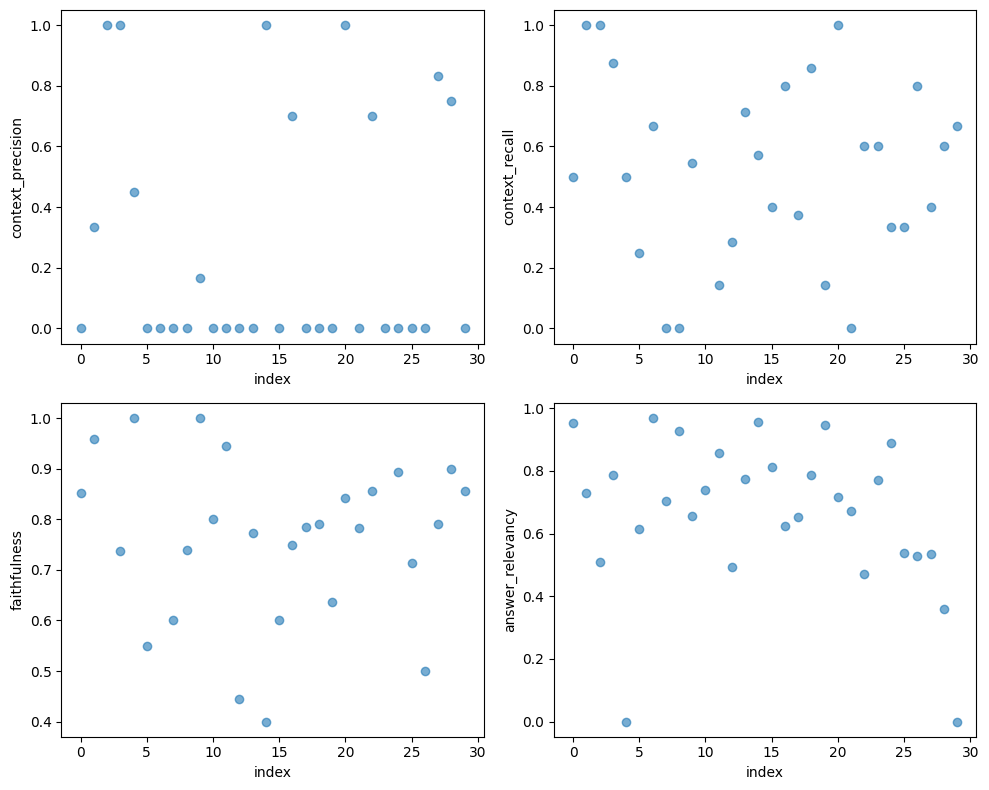

In [ ]:
from datetime import datetime

timestamp = datetime.now().strftime("%m-%d-%H-%M-%S")
filename = f"checkpoint/{timestamp}"

cols_to_plot = ['context_precision', 'context_recall', 'faithfulness', 'answer_relevancy']
# 计算并打印每列均值
print("各列均值统计:")
for col in df.select_dtypes(include=['number']).columns:
    mean_val = df[col].mean()
    print(f"{col}: {mean_val:.2f}")
selected_df = df[cols_to_plot]  # 列筛选
selected_df.to_csv(filename+'.csv', index=False)

import matplotlib.pyplot as plt

# 创建2x2的子图布局
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
# fig.suptitle('', fontsize=16)

# 绘制每个子图
for col, ax in zip(cols_to_plot, axes.flat):
    ax.scatter(range(len(df)), df[col], alpha=0.6)
    ax.set_xlabel('index')
    ax.set_ylabel(f'{col}')

plt.tight_layout()
plt.savefig(filename+'.png')